# Long Term Lake Monitoring - Water Chemistry for Ecoregion 2

THIS IS A WORKING DOCUMENT, AND SO THERE WILL BE TODO NOTES SCATTERED THROUGHOUT, BUT ALL THE CODE RUNS AND DOES WHAT IT IS SUPPOSED TO.

TODO: WRITE UP A MORE DESCRIPTIVE PROJECT SUMMARY, BE FLEXIBLE AS PROJECT EVOLVES
Keywords: aquatic chemistry, drought, alpine limnology, water quality
ID trends in lake chemistry over time

## Import Packages

In [1]:
import os
from glob import glob #might not need
import warnings #might not need

import folium
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.axes._axes import _log as matplotlib_axes_logger
import numpy as np
import pandas as pd

import contextily as ctx
import earthpy as et
import geopandas as gpd
import seaborn as sns

# Import custom module
import functions_for_lakechem as flc

# Suppress a warning about nan values
warnings.simplefilter('ignore') # MIGHT NOT NEED

# A note on downloading the data : 
# As this is research in its preliminary stages, the data are not yet publicly
# available. A working version of the data are shared in the github repository.

# Define a variable for the working directory path.
wd_path = os.path.join(et.io.HOME,
                       "earth-analytics",
                       "data")
# Set the working directory or make the directory if it does not already exist.
if os.path.exists(wd_path):
    os.chdir(wd_path)
    print("The current working directory is", wd_path)
else:
    os.makedirs(wd_path)
    os.chdir(wd_path)
    print("The path does not exist but is being created")

The current working directory is C:\Users\maeve\earth-analytics\data


## Help on the special functions in flc

In [2]:
def param_plot():
    '''
    Parameters
    -----------
    
    
    Returns
    -----------
    plot_obj : 
        A plot object.
    '''

help(flc)

Help on module functions_for_lakechem:

NAME
    functions_for_lakechem - # coding: utf-8

FUNCTIONS
    pull_coords(source_df, site_ID, lat_col, long_col, crs)
        Create a geopandas dataframe (gdf) containing the coordinates for your 
        features of interest (for example, lakes) and a unique identifier for each
        site (for example, the lake name). This is ideal for dataframes containing
        multiple rows of data for a single location. The returned gdf contains
        only unique instances of site names and coordinates - so there are only as
        many rows as you have feature/study locations. This function is meant to 
        give you a more compact gdf to make plotting your study locations easier.
        
        Parameters
        -----------
        source_df : pandas dataframe object
            The dataframe containing site names, coordinates, and data (lake water
            chemistry, for example).
        
        site_ID : str
            The column n

## Open Lake Chemistry and Spatial Data
#### TODO:
* KEEP REG/DUPES IN MIND FOR OUTLIER TESTS - IN SOME CASES DUPE SAMPLE MAY BE MORE REPRESENTATIVE
* IF REG/DUPE SIMILAR/SAME MIGHT BE VALID TO AVG.
* SORT PARAM BY MAGNITUDE FOR OUTLIER TESTS
* SUMMARY STATS TABLE (BY WA, GEOL, PARAM, LAKE, ETC)
* N/S, E/W like Muss.
* (really GEOL should be marine seds vs ign) (careful with map res, mixed geol)

* GROUP LAKES BY GEOLOGY
* THERE ARE 44 CRATER LAKE EXISTS IN 2 PLACES; removed several that are short-only

In [3]:
# Create file paths
lakeproj_path = os.path.join('alpine-lake-chemistry', 'data')
lakechem_path = os.path.join(lakeproj_path,
                             'r2-lt-lake-chem-cleaned.csv')
# TODO: ACCESS PROGRAMMATICALLY???
state_bounds_path = os.path.join(lakeproj_path,
                                 'TIGER2018',
                                 'STATE',
                                 'tl_2018_us_state.shp')

# Open lake chemistry file as a pandas dataframe, indexing by date.
# Clean up some column names and remove trailing whitespace.
lakechem_all = pd.read_csv(lakechem_path,
                           parse_dates=['date'],
                           index_col=['date'],
                           na_values=['NaN'])  # TODO: FILTER NAN VALS?

lakechem_all = lakechem_all.rename(columns={'site-rename': 'site_name'})
lakechem_all['site_name'] = lakechem_all['site_name'].str.rstrip()

# Generate a cleaner gdf for plotting from the coordinates in lakechem_all.
lake_coords = flc.pull_coords(source_df=lakechem_all, site_ID='site_name',
                          lat_col='LAT', long_col='LONG', crs='EPSG:4326')

# Open state boundary shapefiles and select only the states in Ecoregion 2 for
# which longterm data exists.
state_bounds = gpd.read_file(state_bounds_path)
states = ['CO', 'WY']
state_bounds = state_bounds.loc[state_bounds['STUSPS'].isin(states)]

# Optional: take a look!
# lakechem_all.head()
# lake_coords.head()
# state_bounds.head()

## Sort and Filter

In [4]:
# Filter for Ca, pH, ANC, and conductivity...
lakechem_subset = lakechem_all.drop(['UTME', 'UTMN', 'ZONE', 'time',
                                     'monitoring-site-name',
                                     'COMMENT', 'Uncategorized'], axis = 1)
lch_grouped = lakechem_subset.groupby(['site_name'])

# Optional : take a look!
# lakechem_subset.head()

In [5]:
# Create a dictionary for custom colormapping
lakenames = np.concatenate(sorted(lch_grouped['site_name'].unique())).ravel()
colors = sns.color_palette("rainbow", n_colors=len(lakenames))
color_dict = dict(zip(lakenames, colors))

# Plots
### Parameter Plots
#### Specific Conductivity

In [6]:
# anc_plot = lakechem_subset.dropna()
# anc_plot.dtypes

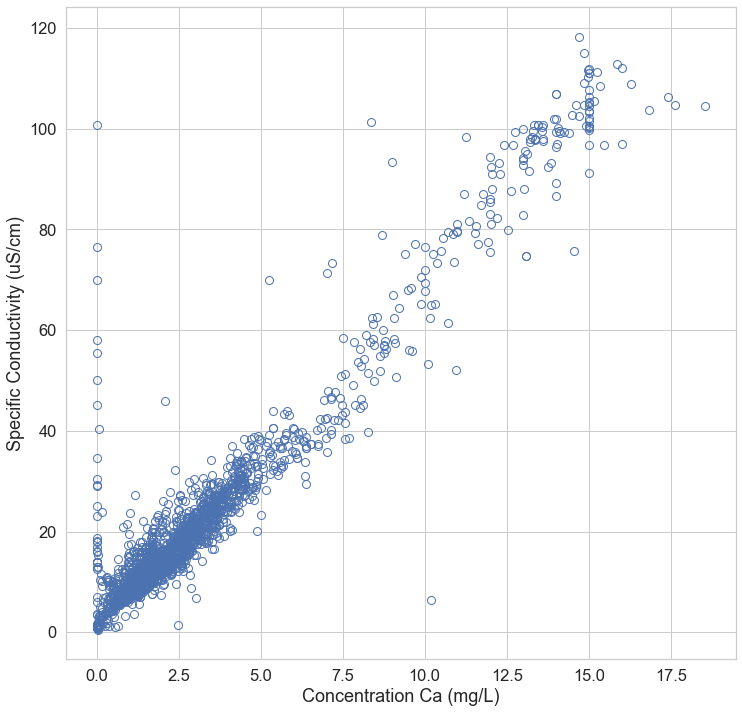

In [7]:
# Prettier plotting with seaborn
# TODO: ADJUST THEME
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

fig1, ax1 = plt.subplots(figsize=(12,12))
ax1.plot(lakechem_subset['Ca'],
         lakechem_subset['specific-conductivity'],
         ls='None',
         marker='o',
         markersize=8,
         mfc='None')
ax1.set(xlabel='Concentration Ca (mg/L)',
       ylabel = 'Specific Conductivity (uS/cm)')
plt.show()

#### ANC

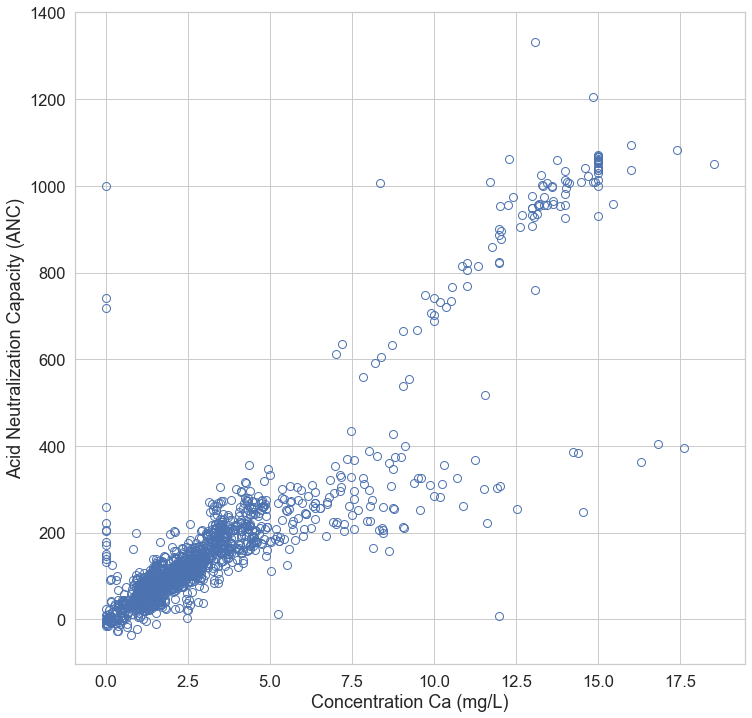

In [8]:
fig2, ax2 = plt.subplots(figsize=(12,12))
ax2.plot(lakechem_subset['Ca'],
         lakechem_subset['ANC'],
         ls='None',
         marker='o',
         markersize=8,
         mfc='None')
ax2.set(xlabel= 'Concentration Ca (mg/L)',
       ylabel = 'Acid Neutralization Capacity (ANC)')
plt.show()

### Timeseries Plots

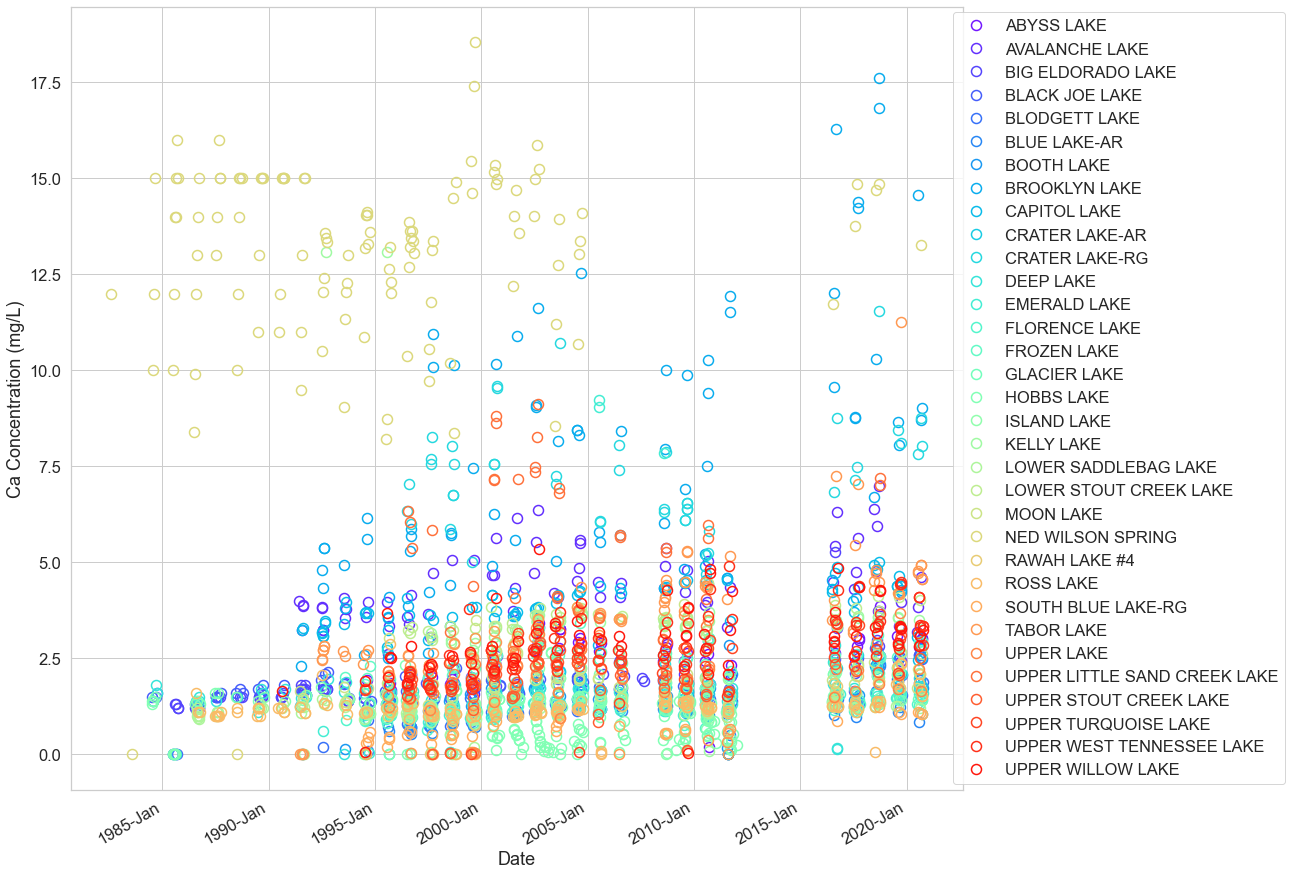

In [9]:
f5, ax5 = plt.subplots(figsize=(16,16))
date_form = DateFormatter('%Y-%b')
ax5.xaxis.set_major_formatter(date_form)

flc.time_plot(lch_grouped, 'Ca', ax5, color_dict)
ax5.set(xlabel='Date',
        ylabel='Ca Concentration (mg/L)')
plt.legend(loc='right', bbox_to_anchor=(1.37, 0.5))

plt.show()

#### manual pH timeseries

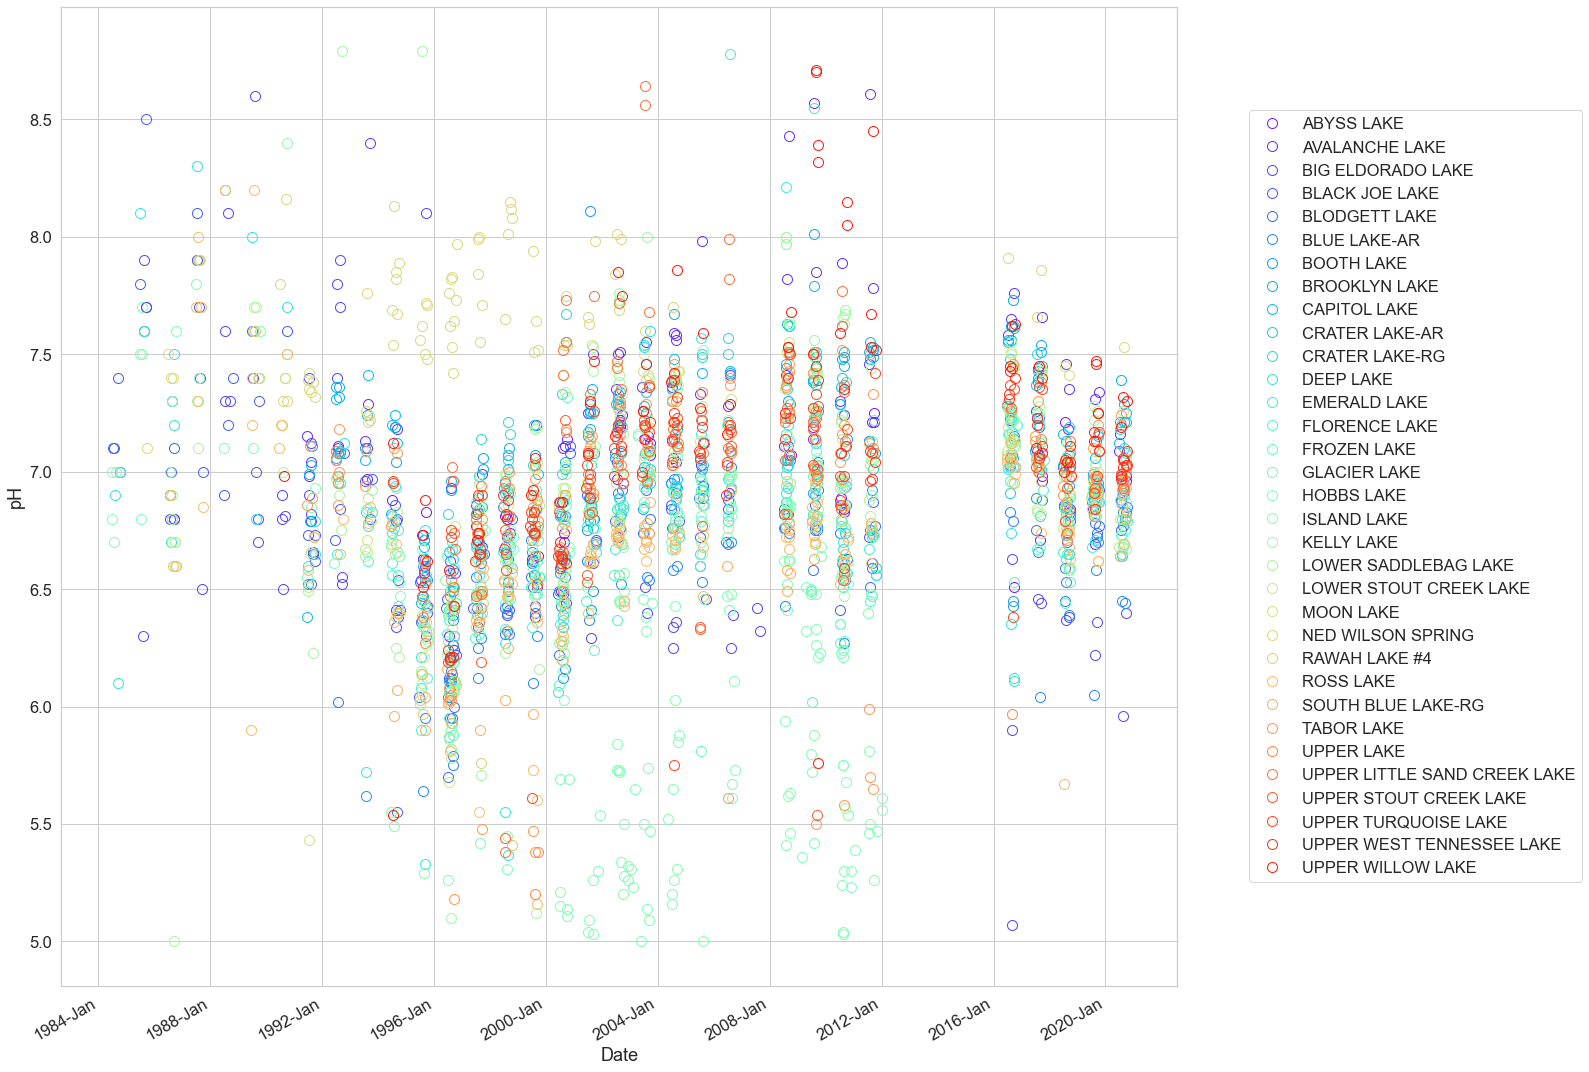

In [10]:
# Construct figure and format date
f2, (ax2) = plt.subplots(figsize=(20, 20))
date_form = DateFormatter("%Y-%b")
ax2.xaxis.set_major_formatter(date_form)

for alake, anarray in lch_grouped['pH']:
    anarray.plot(ax=ax2,
                 ls='None',
                 marker='o',
                 markersize=10,
                 mfc='None',
                 markeredgecolor=color_dict[alake],
                 label=alake)

ax2.set(xlabel='Date',
        ylabel='pH')
plt.legend(loc='right', bbox_to_anchor=(1.37, 0.5))

plt.show()

#### Grouped Timeseries Plots

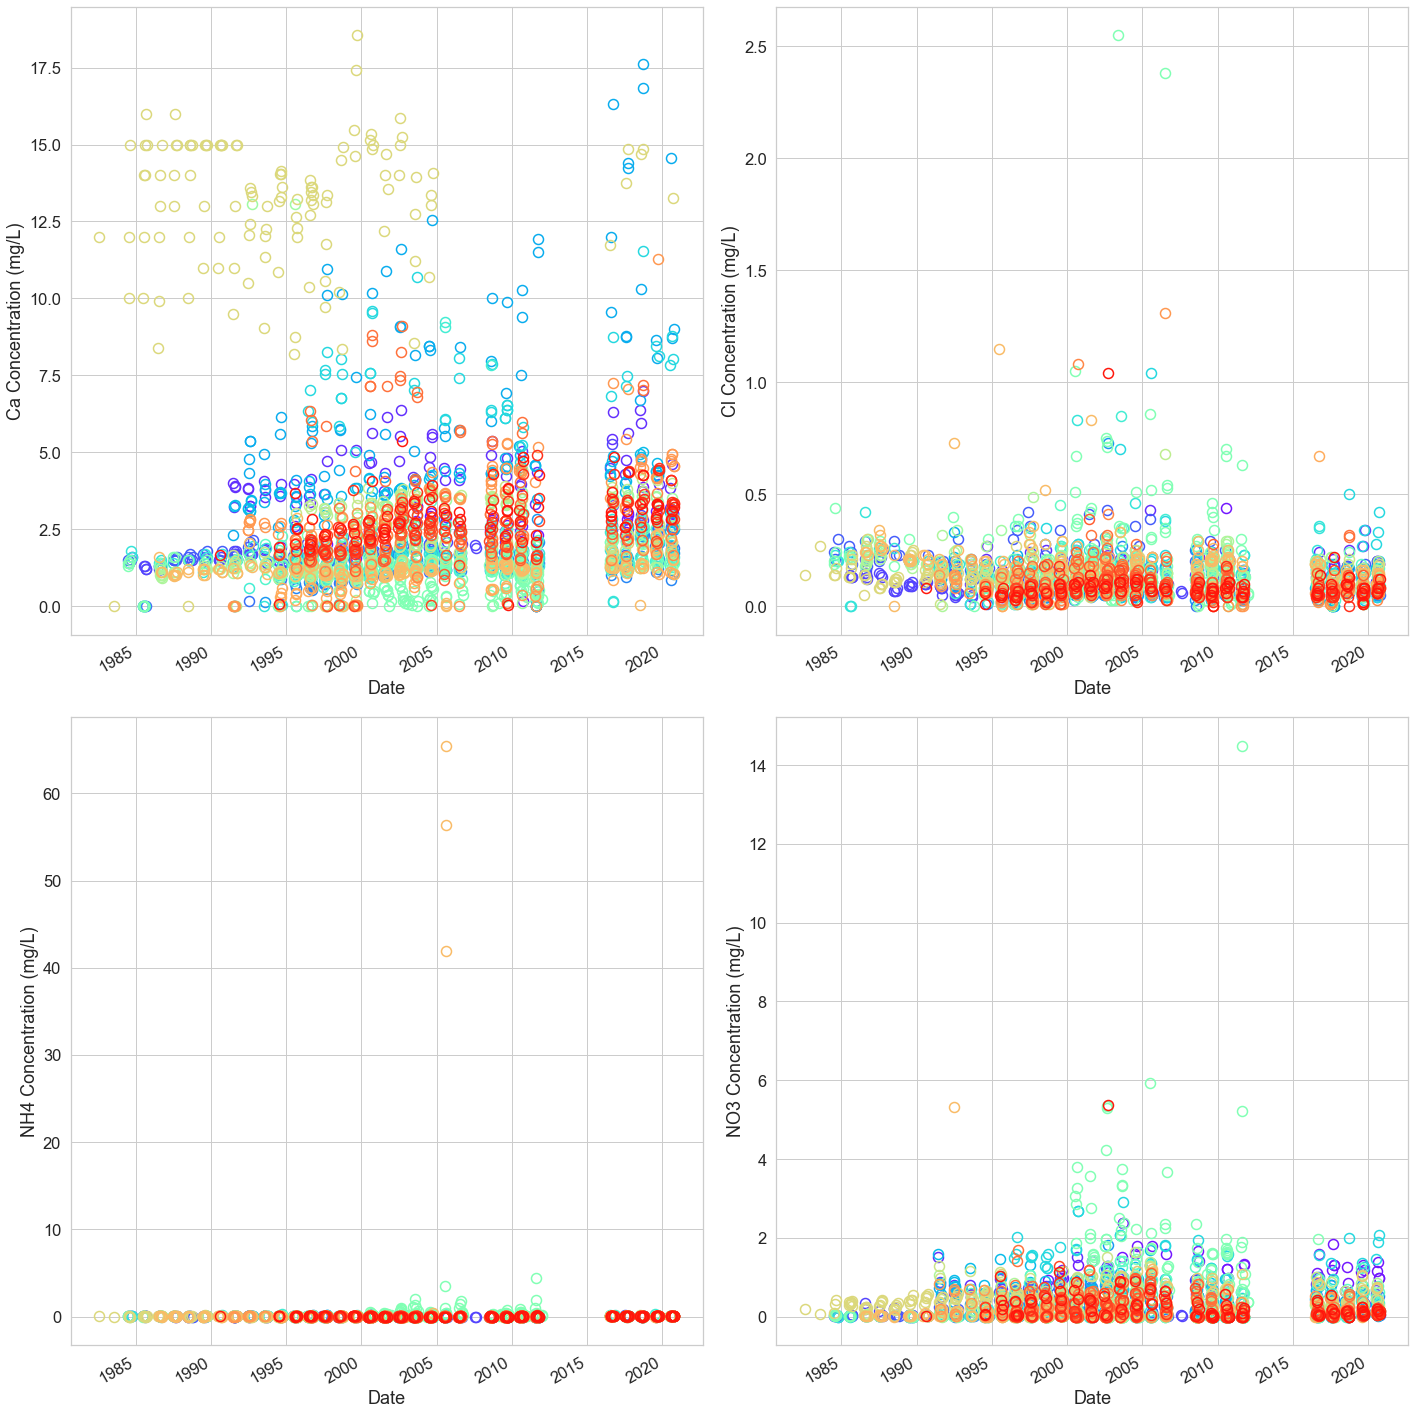

In [15]:
# always need fix no. of sublplots
f3, axes = plt.subplots(2, 2, figsize=(20, 20)) # sharex=True, sharey=True,

ions = ['Ca', 'Cl', 'NH4', 'NO3']
# if odd number, try enumerate (loop iteration number)
# important for 2x2 if it were just 2x1, flattening is less important because array dims are still one row

axes_flat = axes.ravel()
for ax, ion in zip(axes_flat, ions):
    flc.time_plot(lch_grouped, ion, ax, color_dict)
    ax.set(xlabel='Date',
           ylabel=ion + ' Concentration (mg/L)')

#plt.legend(loc='center', bbox_to_anchor=(1.5, 1.1))
plt.tight_layout()
plt.show()


# # TODO: troubleshoot .savefig()
# #plt.savefig('lakechem_fig2.png')

# Map

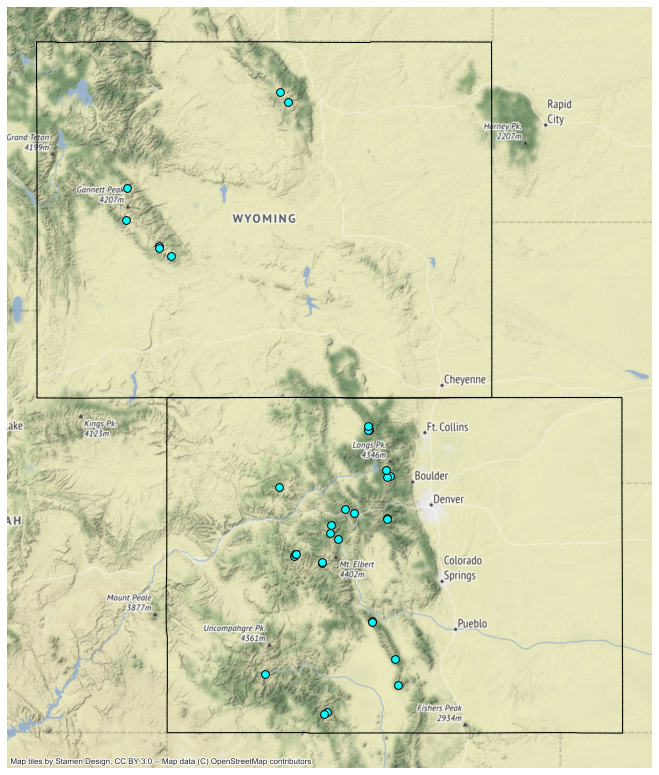

In [16]:
# Convert lake coordinates and state borders to share basemap crs
lake_coords_projected = lake_coords.to_crs(epsg=3857)
states_projected = state_bounds.to_crs(epsg=3857)

# Add a webmap basemap with contextily
fmap, axm = plt.subplots(figsize=(14,14))
states_projected.plot(ax=axm, color='none', edgecolor='black')
lake_coords_projected.plot(ax=axm,
                           marker='o', markersize=60,
                           color='cyan', edgecolor='black')
ctx.add_basemap(axm, url=ctx.providers.Stamen.Terrain)
axm.set_axis_off()

## For later: try to make an interactive map with folium, or possibly Google Earth Engine

In [ ]:
# m = folium.Map(location=[39.0150, -105.2705],
#                tiles='Stamen Terrain',
#                zoom_start=5)

# # This loop adds markers to your map
# for popup_name, xy in lake_coords.groupby(['site_rename']):
#     print(popup_name)
#     print(xy.LAT[0])
#     print(xy.LONG[0])
#     folium.Marker(
#         location=[xy.LAT[0], xy.LONG[0]],
#         popup=popup_name,
#         icon=folium.Icon()
#     ).add_to(m)

# # Show your map!
# m

# SCRATCH CODE

In [ ]:
# Remove blank samples
# if pd.isna(lakechem_subset['SAMPLE TYPE']):
#     lakechem_subset['site_name'] = "NAN"
# else:
#     lakechem_filtered = lakechem_subset.drop([lakechem_subset['SAMPLE TYPE']=='BLANK'], inplace=True)

# len(lakechem_subset), len(lakechem_filtered)
# lakechem_filtered



# fig, ax = plt.subplots(figsize=(10, 6))

# for key, data in plot_data.groupby('site'):
#     data.plot(use_index=True,
#               y='mean_ndvi',
#               ax=ax,
#               marker='o',
#               label=key,
#               color = colorPalette)

#

# THIS WORKS! (but it's unecessarily clunky. Good work-around tho.)
# lakes=[]
# for lake in lakenames:
#     name = lake.rstrip()
#     if name not in lakes:
#         lakes.append(name)
#     #     lakes = lakes.unique() # This doesn't work because now the object is a list
# lakes

# Remove trailing whitespace on strings with .rstrip(), then get only unique
# lake names (there should be 42).
# lakenames = lakechem_subset.site_name.str.rstrip()
# lakenames = lakenames.unique()
# lakenames = lakechem_2016_20.site_name.str.rstrip().unique()
# len(lakenames), lakenames
# RENAMING VALUES IN THE COLUMN WORKS BETTER FOR THIS, BUT IF YOU WANT JUST A LIST OF LAKE NAMES THIS IS GOOD

# TURNS OUT USING ZIP IS NOT THE BEST SOLUTION HERE BECAUSE IT TAKES THE SHORTEST THING TO LIST AND STOPS AFTER THAT
# SO YOU DON'T GET ALL THE DATES
# A test loop
# for adate, anarray, acolor, alake in zip(dates, ca_array, colors, lakenames):
#     print(adate)
#     print(anarray)
#     print(acolor)
#     print(alake)

# for acolor, alake, anarray in zip(colors, lakenames, ca_array):
#     print(acolor)
#     print(alake)
#     print(anarray)

# Create some lists to reference with zip() to streamline plotting
# colors = sns.color_palette("gnuplot2", n_colors=43)
# ca_array = lakechem_subset['Ca']
# dates = lakechem_subset.index.values

# dates_16_20 = lakechem_2016_20.index.values
# for alake, acolor, adate, anarray in zip(lakenames, colors, dates_16_20, lakechem_2016_20['Ca']):
#     ax1.plot(adate,
#              anarray,
#              label=alake,
#              color=acolor,
#              marker='o',
#              markersize=9,
#              mfc='None',
#              ls='None')


# RESOLVED BY USING THE LAMBDA FUNCTION
# lake_lats = np.concatenate(lake_coords_grouped['LAT'].unique()).ravel()
# lake_longs = np.concatenate(lake_coords_grouped['LONG'].unique()).ravel()

# lake_coords = pd.DataFrame({'LAT': lake_lats, 'LONG': lake_longs},
#                            columns=['LAT', 'LONG'])
# lake_coords
# lakechem_all